# Projeto Spark

A ser realizado em duplas.

Entrega: 6 de dezembro de 2022

## Introdução

Neste projeto vamos construir um classificador Naive-Bayes para determinar o sentimento de um comentário.

## Instalando o ambiente

O jeito mais simples de começar a trabalhar com Spark é instalar um container com tudo pronto! No site https://hub.docker.com/r/jupyter/pyspark-notebook vemos uma imagem Docker que já vem com `pyspark` e `jupyter lab`. Instale a imagem com o comando:

```bash
docker pull jupyter/pyspark-notebook
```

Vamos iniciar o ambiente de trabalho com o comando `docker run`. Para isso precisamos tomar alguns cuidados:

1) Temos que mapear nosso diretorio local de trabalho para um diretório interno do container, de modo que alterações feitas dentro do container (nesta pasta escolhida) sejam gravadas no nosso diretorio local. No container temos um usuário padrão com *username* `jovyan`. No *homedir* desse usuario temos uma pasta vazia `work`, que vai servir como local de mapeamento do nosso diretorio local de trabalho. Podemos então fazer esse mapeamendo com a opção `-v` do comando `docker run` da seguinte forma:

```bash
-v <diretorio>:/home/jovyan/work
```

onde `<diretorio>` representa seu diretorio local de trabalho.

2) Para acessar o `jupyter notebook` e o *dashboard* do Spark a partir do nosso *browser* favorito temos que abrir algumas portas do container com a opção `-p`. As portas são `8888` (para o próprio `jupyter notebook`) e `4040` (para o *dashboard* do Spark). Ou seja, adicionaremos às opções do `docker run`o seguinte:

```bash
-p 8888:8888 -p 4040:4040
```

Desta forma, ao acessar `localhost:8888` na nossa máquina, estaremos acessando o servidor Jupyter na porta 8888 interna do container.

3) Vamos iniciar o container no modo interativo, e vamos especificar que o container deve ser encerrado ao fechar o servidor Jupyter. Faremos isso com as opções `-it` e `-rm`

Portanto, o comando completo que eu uso na minha máquina Linux para iniciar o container é:

```bash
docker run \
    -it \
    --rm \
    -p 8888:8888 \
    -p 4040:4040 \
    -v `pwd`:/home/jovyan/work \
    jupyter/pyspark-notebook


```

Para facilitar a vida eu coloco esse comando em um arquivo `inicia.sh`. Engenheiros, façam do jeito que preferirem!

Agora abra esse notebook lá no container!


## Iniciando o Spark

Vamos iniciar o ambiente Spark. Para isso vamos:

1) Criar um objeto de configuração do ambiente Spark. Nossa configuração será simples: vamos especificar que o nome da nossa aplicação Spark é "Minha aplicação", e que o *master node* é a máquina local, usando todos os *cores* disponíveis. Aplicações reais de Spark são configuradas de modo ligeiramente diferente: ao especificar o *master node* passamos uma URL real, com o endereço do nó gerente do *cluster* Spark.

2) Vamos criar um objeto do tipo `SparkContext` com essa configuração

In [1]:
import pyspark

conf = pyspark.SparkConf()
conf.setAppName('Minha aplicação')
conf.setMaster('local[*]')

sc = pyspark.SparkContext(conf=conf)

O `SparkContext` é a nossa porta de entrada para o cluster Spark, ele será a raiz de todas as nossas operações com o Spark.

In [2]:
sc

<SparkContext master=local[*] appName=Minha aplicação>

O link acima provavelmente não funcionará porque ele se refere à porta 4040 interna do container (portanto a URL está com endereço interno). Porém fizemos o mapeamento da porta 4040 interna para a porta 4040 externa, logo você pode acessar o *dashboard* do Spark no endereço http://localhost:4040

<center><img src="./spark_dashboard.png" width=800/></center>

## Lendo os dados

Vamos começar lendo o arquivo de reviews e gravando o resultado em formato pickle, mais amigável.

In [15]:
def parse_line(line):
    parts = line[1:-1].split('","')
    sentiment = int(parts[0])
    title = parts[1].replace('""', '"')
    body = parts[2].replace('""', '"')
    return (sentiment, title, body)

rdd = sc.textFile('train.csv').map(parse_line)

In [16]:
rdd.count()

3600000

In [17]:
rdd.take(1)

[(2,
  'Stuning even for the non-gamer',
  'This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^')]

Agora vamos gravar no formato pickle, para facilitar os trabalhos futuros. Após gravar o arquivo, não mais rode as células desta primeira etapa!

In [18]:
rdd.saveAsPickleFile('reviews.pickle')

## Um classificador Naive-Bayes

Vamos ler o arquivo pickle gravado anteriormente:

In [19]:
rdd = sc.pickleFile('reviews.pickle')

In [20]:
rdd.count()

3600000

In [21]:
rdd.take(1)

[(2,
  'Stuning even for the non-gamer',
  'This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^')]

Agora, complete as tarefas em sequencia para construir o classificador Naive-Bayes:

### Fase 1

#### Tarefa

Construa uma função que recebe um RDD no formato do RDD original e retorna um RDD no qual cada item é um par (palavra, contagem).

In [22]:
import string

In [23]:
def remove_ponctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def split_words(item):
    return remove_ponctuation(item[1]).split() + remove_ponctuation(item[2]).split()

def palavra_contagem(rdd_raw):
    rdd_count = rdd_raw.flatMap(split_words).map(lambda word: (word, 1)).reduceByKey(lambda x, y : x+y)
    return rdd_count

In [24]:
rdd_count = palavra_contagem(rdd)
rdd_count.take(2)

[('out', 782684), ('like', 965412)]

#### Tarefa

Construa uma função que recebe o RDD (palavra, contagem) construido anteriormente e retorna um RDD no qual cada item é um par (palavra, $\log_{10}\left(c \, / \, T\right)$), onde $c$ é a contagem daquela palavra e $T$ é a soma das contagens de palavra.

In [25]:
from numpy import log10

def sum_all(previous, new):
    return ("all", previous[1] + new[1])

def add_log(rdd, total):
    return rdd.map(lambda item: (item[0], log10(item[1]/total)))

In [26]:
total = rdd_count.reduce(sum_all)[1]

rdd_log = add_log(rdd_count, total)
rdd_log.take(2)

[('out', -2.555764545999455), ('like', -2.464638309090318)]

#### Tarefa

Separe o RDD original em dois RDDs: o dos reviews positivos e o dos negativos. Em seguida, use as funções anteriores para construir RDDs que contem os pares (palavra, $\log_{10}\left(c \, / \, T\right)$)

In [27]:
def sentiment_split(rdd):
    rdd_pos = rdd.filter(lambda review: review[0] == 2)
    rdd_neg = rdd.filter(lambda review: review[0] == 1)
    
    return rdd_pos, rdd_neg

In [28]:
rdd_pos, rdd_neg = sentiment_split(rdd)

print(rdd_pos.take(1))
print(rdd_neg.take(1))

[(2, 'Stuning even for the non-gamer', 'This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^')]
[(1, 'Buyer beware', 'This is a self-published book, and if you want to know why--read a few paragraphs! Those 5 star reviews must have been written by Ms. Haddon\'s family and friends--or perhaps, by herself! I can\'t imagine anyone reading the whole thing--I spent an evening with the book and a friend and we were in hysterics reading bits and pieces of it to one another. It is most definitely bad enough to be entered into some kind of a "worst book" contest. I can\'t believe Amazon even sells this kind of thing. Maybe I can offer them my 8th grade term p

In [29]:
rdd_pos_count = palavra_contagem(rdd_pos)
total_pos = rdd_pos_count.reduce(sum_all)[1]

rdd_pos_log = add_log(rdd_pos_count, total_pos)

rdd_pos_log.take(2)

[('out', -2.5897644969597597), ('like', -2.4747862361501625)]

In [30]:
rdd_neg_count = palavra_contagem(rdd_neg)
total_neg = rdd_neg_count.reduce(sum_all)[1]

rdd_neg_log = add_log(rdd_neg_count, total_neg)

rdd_neg_log.take(2)

[('book', -2.211221702630697), ('family', -3.807023215978198)]

### Tarefa

Use o `.fullOuterJoin()` dos RDDs para construir um RDD unificado, no qual cada item é da forma (palavra, log_prob_positivo, log_prob_negativo). "Baixe" esse resultado final usando `.collect()`.

In [31]:
rdd_log_pos_neg = rdd_pos_log.fullOuterJoin(rdd_neg_log)

rdd_log_pos_neg.take(10)

[('out', (-2.5897644969597597, -2.5264979053685646)),
 ('Stars', (-4.508101761741771, -4.657702611951504)),
 ('family', (-3.3543939677236634, -3.807023215978198)),
 ('start', (-3.506996488996986, -3.58927197577693)),
 ('willing', (-4.4567539190833605, -4.354650443697687)),
 ('Electronics', (-5.7492305938048425, -5.422023353074132)),
 ('AC', (-4.880583716916467, -4.735965972881876)),
 ('gift', (-3.4913330402318556, -3.7414534478117143)),
 ('Houston', (-5.12606712387593, -5.323389013923975)),
 ('southside', (-6.699883872220723, -7.085567238331205))]

In [32]:
log_pos_neg = rdd_log_pos_neg.collect()

In [33]:
dic_log_pos_neg = {}

for item in log_pos_neg:
    word = item[0]
    pos = item[1][0]
    neg = item[1][1]
    dic_log_pos_neg[word] = {"pos":pos, "neg":neg}

dic_log_pos_neg["out"]

{'pos': -2.5897644969597597, 'neg': -2.5264979053685646}

#### Tarefa

Para uma dada string, determine se ela é um review positivo ou negativo usando os RDDs acima. Lembre-se de como funciona o classificador Naive-Bayes: http://stanford.edu/~jurafsky/slp3/slides/7_NB.pdf, consulte tambem suas notas de aula de Ciência dos Dados!

In [34]:
def naive_bayes(dic_train, string):
    string_list = string.split()
    pos, neg = 0, 0
    
    for word in string_list:
        if word in dic_train.keys():
            prob_pos = dic_train[word]["pos"]
            prob_neg = dic_train[word]["neg"]
            
            pos += prob_pos if prob_pos != None else 0
            neg += prob_neg if prob_neg != None else 0
            
    if pos > neg:
        # print(f"Positive. Prob: {pos}")
        return 2
    
    # print(f"Negative. Prob: {pos}")
    return 1

In [35]:
naive_bayes(dic_log_pos_neg, "This is a self-published book, and if you want to know why--read a few paragraphs!")

2

### Fase 2

Agora que temos um classificador Naive-Bayes, vamos explorá-lo um pouco:

### Tarefa

Quais são as 100 palavras que mais indicam negatividade, ou seja, onde a diferença entre a probabilidade da palavra no conjunto dos comentários negativos e positivos é máxima? E quais as 100 palavras de maior positividade? Mostre os resultados na forma de *word clouds*.

In [36]:
top100_neg = rdd_log_pos_neg \
                .filter(lambda x: x[1][0] != None and x[1][1] != None) \
                .map(lambda x: (x[0], x[1][1] - x[1][0])) \
                .sortBy(lambda x: x[1], ascending = False) \
                .take(100)

top100_pos = rdd_log_pos_neg \
                .filter(lambda x: x[1][0] != None and x[1][1] != None) \
                .map(lambda x: (x[0], x[1][0] - x[1][1])) \
                .sortBy(lambda x: x[1], ascending = False) \
                .take(100)

In [37]:
top100_neg[:4]

[('Worthless', 2.3249416489503156),
 ('SecuROM', 2.252056461008654),
 ('Unimpressed', 2.245252752953709),
 ('Unsatisfactory', 2.242960956174124)]

In [38]:
top100_pos[:4]

[('Bookwatch', 2.147444200305956),
 ('Excelente', 2.069597193347396),
 ('Exelent', 1.9779835201492881),
 ('McVay', 1.9419858668777694)]

In [43]:
#!pip install wordcloud

In [40]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

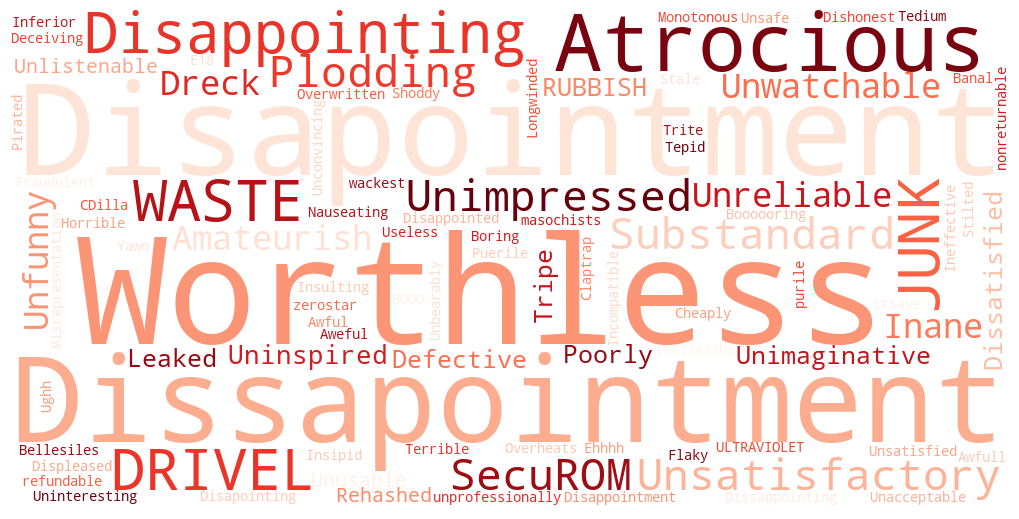

In [41]:
top100_neg_list = " ".join([item[0] for item in top100_neg])
wordcloud_neg = WordCloud(colormap = "Reds", background_color="white", width = 1000, height = 500,).generate(top100_neg_list)

plt.figure(figsize = (10, 5), facecolor = None)
plt.imshow(wordcloud_neg)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

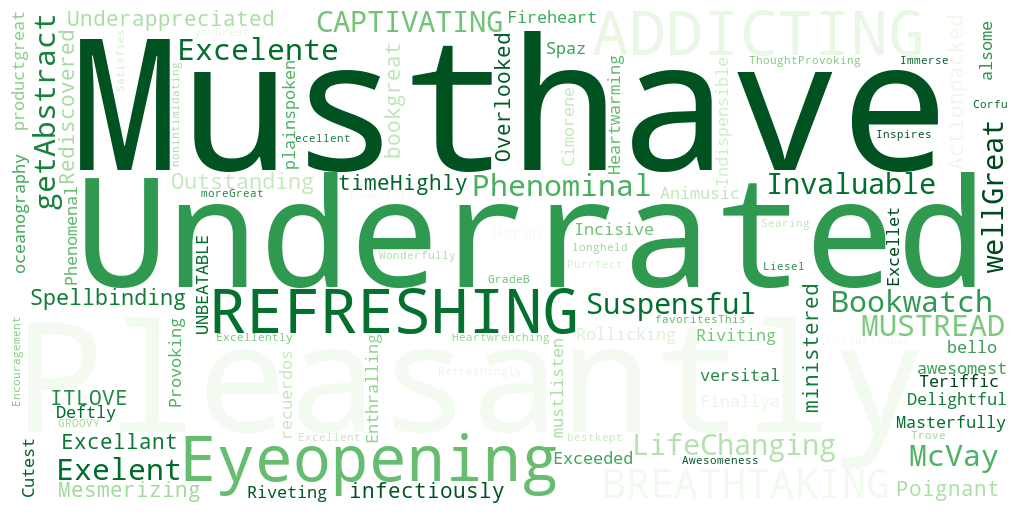

In [42]:
top100_pos_list = " ".join([item[0] for item in top100_pos])
wordcloud_pos = WordCloud(colormap = "Greens", background_color="white", width = 1000, height = 500,).generate(top100_pos_list)

plt.figure(figsize = (10, 5), facecolor = None)
plt.imshow(wordcloud_pos)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

### Tarefa desafio!

Qual o desempenho do classificador (acurácia)? Para medir sua acurácia:

- Separe os reviews em dois conjuntos: treinamente e teste
- Repita o "treinamento" do classificador com o conjunto de treinamento
- Para cada review do conjunto de teste, determine se é positiva ou negativa de acordo com o classificador
- Determine a acurácia

Esta não é uma tarefa trivial. Não basta fazer um `for` para determinar a classe de cada review de teste: isso demoraria uma eternidade. Você tem que usar variáveis "broadcast" do Spark para enviar uma cópia da tabela de frequencias para cada *core* do executor.

In [44]:
train, test = rdd.randomSplit(weights=[80, 20], seed=27)


# Split de sentimento
rdd_pos_train, rdd_neg_train = sentiment_split(train)


# Contagem de palavras POS e log
rdd_pos_train_count = palavra_contagem(rdd_pos_train)
total_pos_train = rdd_pos_train_count.reduce(sum_all)[1]

rdd_pos_train_log = add_log(rdd_pos_train_count, total_pos_train)

rdd_pos_train_log.take(1)


# Contagem de palavras NEG
rdd_neg_train_count = palavra_contagem(rdd_neg_train)
total_neg_train = rdd_neg_train_count.reduce(sum_all)[1]

rdd_neg_train_log = add_log(rdd_neg_train_count, total_neg_train)

rdd_neg_train_log.take(1)


# Agregando POS e NEG

rdd_log_pos_neg_train = rdd_pos_train_log.fullOuterJoin(rdd_neg_train_log)

rdd_log_pos_neg_train.take(1)

log_pos_neg_train = rdd_log_pos_neg_train.collect()


# Pivotando dados
dic_log_pos_neg_train = {}

for item in log_pos_neg_train:
    word = item[0]
    pos = item[1][0]
    neg = item[1][1]
    dic_log_pos_neg_train[word] = {"pos":pos, "neg":neg}


# Resultado teste para o treino
naive_bayes(dic_log_pos_neg_train, "This is a self-published book, and if you want to know why--read a few paragraphs!")

2

In [45]:
def execute(review):
    text = remove_ponctuation(review[1]) + " " + remove_ponctuation(review[2])
    result = naive_bayes(dic_log_pos_neg_train, text)
    
    #       resposta   previsão
    return (review[0], result)

In [46]:
result = test.map(execute)
result.take(2)

[(2, 1), (2, 1)]

In [47]:
def count_match(item):
    if item[0] == item[1]:
        return 1
    return 0

total = len(sc.broadcast(result.collect()).value)  # OU results.count()
acertos = result.map(count_match).sum()

print(f"Acurácia: {(acertos/total)*100}%")

Acurácia: 77.59158033729138%


### Tarefa desafio!

Implemente Laplace smoothing

## Rubrica de avaliação

- I: groselha, falha crítica, ou não entregou nada
- D: Fez uma tentativa honesta de fazer todos os itens da fase 1, mas tem erros
- C: Fase 1 completa
- B: Fase 2, faltando apenas um desafio
- A: Fase 2 completa